In [125]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Prepping the data.

I will be using a dataset on cereal, with nutritional facts for 77 different brands. My outcome variable will be rating.

In [126]:
cereal = pd.read_csv('cereal.csv')

In [127]:
cereal.head()

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100% Bran,N,C,70,4,1,130,10.000,5.000,6,280,25,3,1.000,0.330,68.403
1,100% Natural Bran,Q,C,120,3,5,15,2.000,8.000,8,135,0,3,1.000,1.000,33.984
2,All-Bran,K,C,70,4,1,260,9.000,7.000,5,320,25,3,1.000,0.330,59.426
3,All-Bran with Extra Fiber,K,C,50,4,0,140,14.000,8.000,0,330,25,3,1.000,0.500,93.705
4,Almond Delight,R,C,110,2,2,200,1.000,14.000,8,-1,25,3,1.000,0.750,34.385


In [128]:
print(cereal.isnull().sum())
print('\n')
print(cereal.info())
print('\n')
print(cereal.describe())

name        0
mfr         0
type        0
calories    0
protein     0
fat         0
sodium      0
fiber       0
carbo       0
sugars      0
potass      0
vitamins    0
shelf       0
weight      0
cups        0
rating      0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
name        77 non-null object
mfr         77 non-null object
type        77 non-null object
calories    77 non-null int64
protein     77 non-null int64
fat         77 non-null int64
sodium      77 non-null int64
fiber       77 non-null float64
carbo       77 non-null float64
sugars      77 non-null int64
potass      77 non-null int64
vitamins    77 non-null int64
shelf       77 non-null int64
weight      77 non-null float64
cups        77 non-null float64
rating      77 non-null float64
dtypes: float64(5), int64(8), object(3)
memory usage: 9.7+ KB
None


       calories  protein    fat  sodium  fiber  carbo  sugars  potass  \
count    77.000   77.00

In [129]:
# determine categorical variables.
for col in cereal.columns:
    print('There are {} unique values for {}'.format((len(cereal[col].unique())),col))

There are 77 unique values for name
There are 7 unique values for mfr
There are 2 unique values for type
There are 11 unique values for calories
There are 6 unique values for protein
There are 5 unique values for fat
There are 27 unique values for sodium
There are 13 unique values for fiber
There are 22 unique values for carbo
There are 17 unique values for sugars
There are 36 unique values for potass
There are 3 unique values for vitamins
There are 3 unique values for shelf
There are 7 unique values for weight
There are 12 unique values for cups
There are 77 unique values for rating


In [130]:
# look at correlations.
corr = cereal.corr().loc[:, 'rating'].abs().sort_values(ascending=False)
corr

rating     1.000
sugars     0.760
calories   0.689
fiber      0.584
protein    0.471
fat        0.409
sodium     0.401
potass     0.380
weight     0.298
vitamins   0.241
cups       0.203
carbo      0.052
shelf      0.025
Name: rating, dtype: float64

Catgeorical variables: mfr, type, shelf, fat, vitamins, weight, and protein. Will not include shelf, weight or vitamins.

Note, some of these categorical variables could be treated as ordinal but I will continue to treat them as categorical.

Also, carbs, sugars, and potassium have negative values so i will not include those.

In [131]:
clean_cereal = cereal.copy()

In [132]:
# drop shelf, weight, vitamins.
clean_cereal = clean_cereal.drop(['shelf', 'vitamins', 'weight'], axis=1)

# remove rows with negitve values in carbo, sugars and potass.
clean_cereal = clean_cereal[clean_cereal.carbo != -1]
clean_cereal = clean_cereal[clean_cereal.sugars != -1]
clean_cereal = clean_cereal[clean_cereal.potass != -1]

In [133]:
clean_cereal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 13 columns):
name        74 non-null object
mfr         74 non-null object
type        74 non-null object
calories    74 non-null int64
protein     74 non-null int64
fat         74 non-null int64
sodium      74 non-null int64
fiber       74 non-null float64
carbo       74 non-null float64
sugars      74 non-null int64
potass      74 non-null int64
cups        74 non-null float64
rating      74 non-null float64
dtypes: float64(4), int64(6), object(3)
memory usage: 8.1+ KB


In [134]:
clean_cereal[['fat', 'protein']] = clean_cereal[['fat', 'protein']].astype(object)
clean_cereal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 13 columns):
name        74 non-null object
mfr         74 non-null object
type        74 non-null object
calories    74 non-null int64
protein     74 non-null object
fat         74 non-null object
sodium      74 non-null int64
fiber       74 non-null float64
carbo       74 non-null float64
sugars      74 non-null int64
potass      74 non-null int64
cups        74 non-null float64
rating      74 non-null float64
dtypes: float64(4), int64(4), object(5)
memory usage: 8.1+ KB


In [135]:
# make dummy variables for categorical features
cereal_feat = pd.get_dummies(clean_cereal[['mfr', 'fat', 'protein']])

In [136]:
# look at relationship with continuous variables and ratings
corr = clean_cereal.corr().loc[:, 'rating'].abs().sort_values(ascending=False)
corr

rating     1.000
sugars     0.756
calories   0.694
fiber      0.603
potass     0.416
sodium     0.383
cups       0.223
carbo      0.056
Name: rating, dtype: float64

In [137]:
from IPython.display import display
corr_matrix = clean_cereal.corr()
display(corr_matrix)

,calories,sodium,fiber,carbo,sugars,potass,cups,rating
calories,1.000,0.296,-0.295,0.271,0.569,-0.071,0.089,-0.694
sodium,0.296,1.000,-0.071,0.328,0.037,-0.039,0.120,-0.383
fiber,-0.295,-0.071,1.000,-0.379,-0.151,0.912,-0.514,0.603
carbo,0.271,0.328,-0.379,1.000,-0.452,-0.365,0.358,0.056
sugars,0.569,0.037,-0.151,-0.452,1.000,0.001,-0.032,-0.756
potass,-0.071,-0.039,0.912,-0.365,0.001,1.000,-0.502,0.416
cups,0.089,0.120,-0.514,0.358,-0.032,-0.502,1.000,-0.223
rating,-0.694,-0.383,0.603,0.056,-0.756,0.416,-0.223,1.000


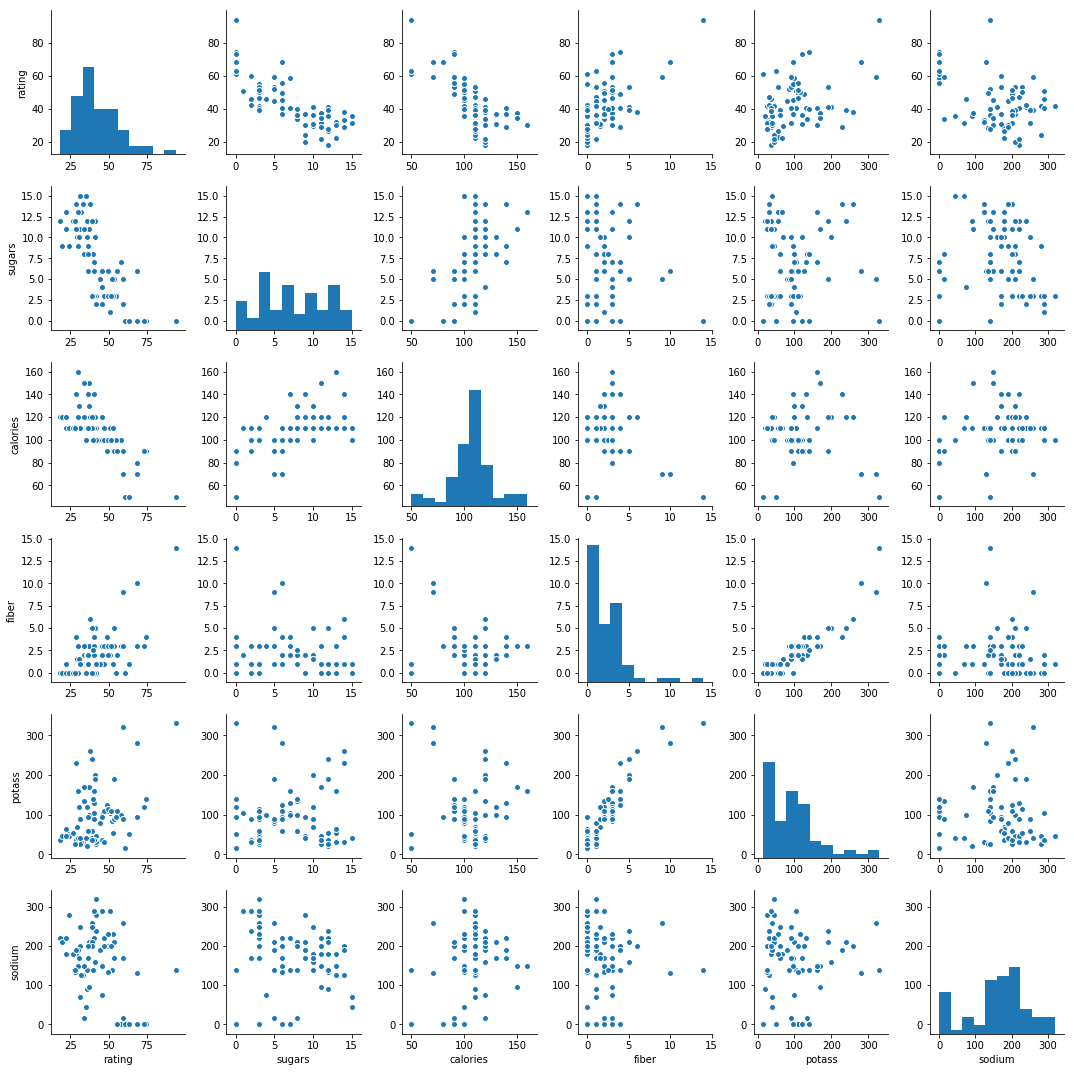

In [138]:
# create pairplot to examine the relationships with rating.
# exclude cups and carbo, they have low correlations with rating.

clean_cereal = clean_cereal.drop(['cups','carbo'],axis=1)

sns.pairplot(clean_cereal[['rating', 'sugars', 'calories', 'fiber', 'potass', 'sodium']])

In [139]:
# dropping sodium due to its lack of linear relationship with ratings.
# fiber and potass are highly correlated. Consider combining as one feature.

means = clean_cereal[['potass', 'fiber']].mean(axis=0)
stds = clean_cereal[['potass', 'fiber']].std(axis=0)
cereal_feat['pot_fib'] = ((clean_cereal[['potass', 'fiber']]-means)/stds).mean(axis=1)

In [140]:
# add sugar and calories to feature dataframe.
cereal_feat['sugars'] = clean_cereal['sugars']
cereal_feat['calories'] = clean_cereal['calories']

In [141]:
cereal_feat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 0 to 76
Data columns (total 20 columns):
mfr_A        74 non-null uint8
mfr_G        74 non-null uint8
mfr_K        74 non-null uint8
mfr_N        74 non-null uint8
mfr_P        74 non-null uint8
mfr_Q        74 non-null uint8
mfr_R        74 non-null uint8
fat_0        74 non-null uint8
fat_1        74 non-null uint8
fat_2        74 non-null uint8
fat_3        74 non-null uint8
fat_5        74 non-null uint8
protein_1    74 non-null uint8
protein_2    74 non-null uint8
protein_3    74 non-null uint8
protein_4    74 non-null uint8
protein_6    74 non-null uint8
pot_fib      74 non-null float64
sugars       74 non-null int64
calories     74 non-null int64
dtypes: float64(1), int64(2), uint8(17)
memory usage: 6.0 KB


In [142]:
# Time to scale. only select numeric variables to scale.
df_num = cereal_feat.select_dtypes(include=[np.number]).dropna()

# Save column names
names = df_num.columns

# Scale and turn teh resulting numpy array back into a dataframe with the correct column names.
cereal_scaled = pd.DataFrame(preprocessing.scale(df_num), columns=names, index=clean_cereal.index)

In [143]:
# Time to select the best features.
# For this, I'll look at correlations with our target variable.
# Need to add ratings to our data frame as well.
cereal_scaled['rating'] = clean_cereal['rating']
corrmat = cereal_scaled.corr()
#top 10 feats
print(corrmat.rating.abs().sort_values(ascending=False).iloc[1:11])

sugars      0.756
calories    0.694
pot_fib     0.521
mfr_N       0.508
fat_0       0.471
protein_1   0.427
mfr_G       0.368
protein_4   0.323
fat_2       0.219
fat_1       0.208
Name: rating, dtype: float64


## OLS Regression

In [145]:
from sklearn import linear_model
regr = linear_model.LinearRegression()

data = cereal_scaled[['sugars', 'calories', 'pot_fib', 'mfr_N', 'fat_0', 'protein_1', 'mfr_G', 'protein_4', 'fat_2', 'fat_1']]
target = cereal_scaled['rating']

regr.fit(data, target)
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(data,target))


Coefficients: 
 [-6.01934354 -3.14164478  4.49185202  2.00958371  3.5879863  -1.94001013
 -1.20133545  1.12692254  0.80435241  1.27925419]

Intercept: 
 42.3717869324

R-squared:
0.930700718811


In [149]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

data_train, data_test, target_train, target_test = model_selection.train_test_split(
    data, target, test_size=0.30, random_state=42)

# Fit our model to the data.
regr.fit(data_train, target_train)

# Classify, storing the result in a new variable.
test_pred = regr.predict(data_test)
train_pred = regr.predict(data_train)

print('\nTraining Coefficients: \n', regr.coef_)
print('\nTraining Intercept: \n', regr.intercept_)
print('\nTraining R-squared:')
print('The R^2 value for train set: {}', format(regr.score(data_train, target_train)))
print('The R^2 value for test set: {}', format(regr.score(data_test, target_test)))


Training Coefficients: 
 [-6.54371061 -3.1463199   4.88247862  2.79397807  2.72205779 -1.24707023
 -1.71650754  1.39083667  1.51434701  1.29778146]

Training Intercept: 
 42.3915068655

Training R-squared:
The R^2 value for train set: {} 0.9370912501128594
The R^2 value for test set: {} 0.846274011068691


Even though our R^2 is fairly high and there could be possible overfitting, I am going to leave as is for right now.

In [150]:
from sklearn.model_selection import cross_val_predict
predict = cross_val_predict(regr, data, target, cv=5)
actual = target
error = (np.mean((actual-predict)**2))**.5
print(error)

5.26666494185213


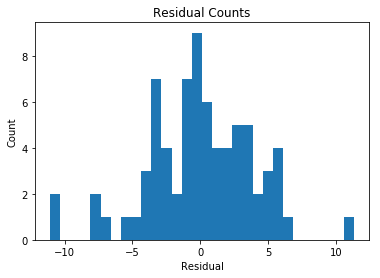

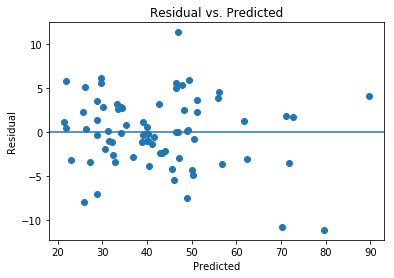

In [153]:
predicted = regr.predict(data)
actual = target

# Calculate residuals.
residual = actual - predicted
residual = pd.to_numeric(residual)

# Histogram of resiuals
plt.hist(residual, bins=30)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.xlim()
plt.show()

plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

High R^2. Pretty good model. Let's try KNN.

## KNN Regression

In [156]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(cereal_feat[['sugars', 'calories', 'pot_fib', 'mfr_N', 'fat_0', 'protein_1','mfr_G', 'protein_4',
                          'fat_2', 'fat_1']])
Y = clean_cereal.rating
knn.fit(X,Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [158]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print('\nEach Cross Validated R^2 Score: \n', score)
print('\nUnweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))


Each Cross Validated R^2 Score: 
 [ 0.6925183   0.34191649  0.68325152  0.48030735  0.5984446 ]

Unweighted Accuracy: 0.56 (+/- 0.27)


Very low R^2. let's scale our inputs.

In [159]:
from sklearn.preprocessing import MinMaxScaler
from sklearn import neighbors
scaler = MinMaxScaler()

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(cereal_feat[['sugars', 'calories', 'pot_fib', 'mfr_N', 'fat_0', 'protein_1','mfr_G', 'protein_4',
                          'fat_2', 'fat_1']])
X_norm = scaler.fit_transform(X)
Y = clean_cereal.rating
knn.fit(X_norm,Y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X_norm, Y, cv=5)
print('\nEach Cross Validated R^2 Score: \n', score)
print('\nUnweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))


Each Cross Validated R^2 Score: 
 [ 0.52937795  0.54370826  0.40479135  0.21807929  0.35222527]

Unweighted Accuracy: 0.41 (+/- 0.24)


Still not great. Let's look at the featurs from OLS model that have highest correlation to rating.

In [160]:
knn = neighbors.KNeighborsRegressor(n_neighbors=5)
X = pd.DataFrame(cereal_feat[['sugars', 'calories', 'pot_fib']])
X_norm = scaler.fit_transform(X)
Y = clean_cereal.rating
knn.fit(X_norm, Y)

from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X_norm, Y, cv=5)
print('\nEach Cross Validated R^2 Score: \n', score)
print('\nUnweighted Accuracy: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))


Each Cross Validated R^2 Score: 
 [ 0.742222    0.51209123  0.81242877  0.87602278  0.55019042]

Unweighted Accuracy: 0.70 (+/- 0.29)


Accuracy is better but still not as good as my OLS model. Let's try weighting my neighbors.

In [162]:
knn_w = neighbors.KNeighborsRegressor(n_neighbors=5, weights='distance')
knn_w.fit(X_norm, Y)

score_w = cross_val_score(knn_w, X_norm, Y, cv=5)
print('\nEach Cross Validated R^2 Score: \n', score_w)
print('\nWeighted Accuracy: %0.2f (+/- %0.2f)' % (score_w.mean(), score_w.std() * 2))


Each Cross Validated R^2 Score: 
 [ 0.74038143  0.53904589  0.80362764  0.81206763  0.57055427]

Weighted Accuracy: 0.69 (+/- 0.23)


This is just about the same as the Unweighted Model.

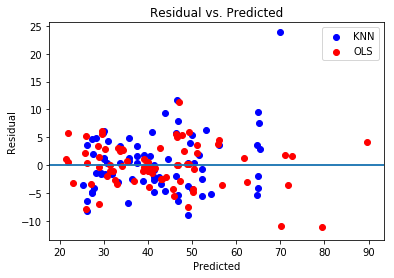

In [164]:
# Let's look at the extracted predicted values.

#OLS
predicted_ols = regr.predict(data)
actual_ols = target

#KNN
predicted_k = knn.predict(X_norm)
actual_k = Y

# Calculate residuals
residual_ols = actual_ols - predicted_ols
residual_ols = pd.to_numeric(residual_ols)

residual_k = actual_k - predicted_k
residual_k = pd.to_numeric(residual_k)

# Plot
plt.scatter(predicted_k, residual_k, c='b', label='KNN')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend()
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.scatter(predicted_ols, residual_ols, c='r', label='OLS')
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.legend()
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Data Points are pretty close together, but the range of the OLS predicted values are higher. This is because the alargest value the nearest neighbor model can predict has to be the largest value in the training set, which also needs to be the nearest neighbor. The KNN model with weighted averages will not return our max predicted value. Therefore, I would choose my OLS model.